### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

#### 1. 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A beginner-friendly Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from your documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


In [5]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model


os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [6]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002007E939D10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002007E93A0D0>, root_client=<openai.OpenAI object at 0x000002007E939A90>, root_async_client=<openai.AsyncOpenAI object at 0x000002007E939E50>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [12]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [10]:
tavily_tool=TavilySearch(max_results=5)

In [17]:
## Generic function to crate a retrieval tool 

def make_retriever_tool_from_text(file, name, desc):
    docs = TextLoader(file, encoding='utf-8').load()

    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)

    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())

    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)

In [ ]:
internal_tool_1=make_retriever_tool_from_text("research_notes.txt",
                                              "InternalResearchNotes ",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x00000200745E0E00>)

In [19]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [20]:
def get_next_node(last_message: BaseMessage, goto:str):
    if "FINAL_ANSWER" in last_message.content:
        return END
    return goto

In [21]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

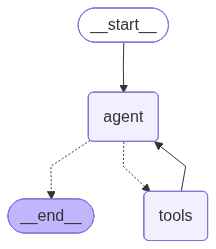

In [22]:
### Research agent and node


research_agent = create_react_agent(
    llm, 
    tools = [internal_tool_1, tavily_tool],
    prompt=make_system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
    " You are working with a content writer colleague.")
)

research_agent


In [23]:
### Research Node

from typing import Literal


def research_node(state:MessagesState) -> Command[Literal['blog_generator', END]]:
    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "blog_generator")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


In [24]:
### Blog write agent
blog_agent=create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        "You can only write a detailed blog. You are working with a researcher colleague."
    )
)

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="blog_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

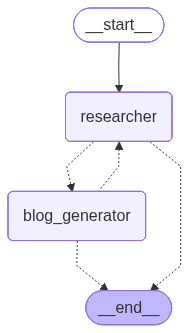

In [25]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
graph

In [ ]:
response=graph.invoke({"messages":"Write a detailed blog on transformer variants in production deployments"})

In [ ]:
response["messages"][-1].content